In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import seaborn as sns

In [2]:
#setup data correctly
#Import data
df_wiki = pd.read_csv("error_wiki_test.csv")
df_utk_uncrop = pd.read_csv("utk_uncropped_age_predictions.csv")
df_utk_crop = pd.read_csv("utk_face_predictions.csv")
df_retrain = pd.read_csv("utk_uncropped_retrained_age.csv")

#drop colunmns
df_wiki = df_wiki.drop(["Unnamed: 0"], axis=1)

#drop colunmns
df_utk_uncrop = df_utk_uncrop.drop(["Unnamed: 0", "date&time", "filename"], axis=1)
df_utk_uncrop["race"] = df_utk_uncrop["race"].replace({0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Other"})
df_utk_uncrop["gender"] = df_utk_uncrop["gender"].replace({0:"Female", 1:"Male"})

#drop colunmns
df_utk_crop = df_utk_crop.drop(["Unnamed: 0", "date&time", "filename"], axis=1)
df_utk_crop["race"] = df_utk_crop["race"].replace({0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Other"})
df_utk_crop["gender"] = df_utk_crop["gender"].replace({0:"Female", 1:"Male"})

#drop colunmns
df_retrain = df_retrain.drop(["Unnamed: 0", "filename"], axis=1)
df_retrain["race"] = df_retrain["race"].replace({0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Other"})
df_retrain["gender"] = df_retrain["gender"].replace({0:"Female", 1:"Male"})

df_retrain.head()

,age,gender,race,pixels,Weighted_Avg,ArgMax
0,29,Female,Asian,[241. 186. 59. ... 242. 178. 72.],38.196539,26
1,26,Female,White,[1. 2. 4. ... 3. 3. 3.],28.368421,26
2,30,Male,Black,[38. 34. 23. ... 73. 75. 64.],31.629167,26
3,28,Male,Asian,[ 93. 134. 196. ... 119. 135. 168.],39.201895,26
4,56,Female,Indian,[54. 50. 39. ... 19. 9. 7.],48.839425,58


### Aggregate

In [3]:
df_utk_uncrop["race"].value_counts()

White     8358
Black     4306
Indian    3417
Asian     2449
Other     1206
Name: race, dtype: int64

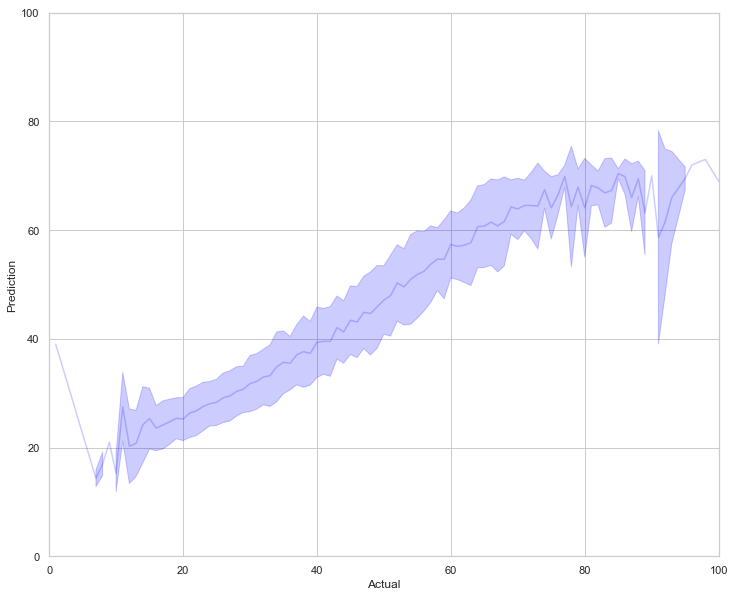

RMSE:  7.2
MAE : 5.3


In [4]:
# Plot the responses for different events and regions
plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="Actual", y="Prediction", data=df_wiki, ci="sd", alpha=0.2, color = "blue")
axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = df_wiki["Actual"]
Y_pred = df_wiki["Prediction"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

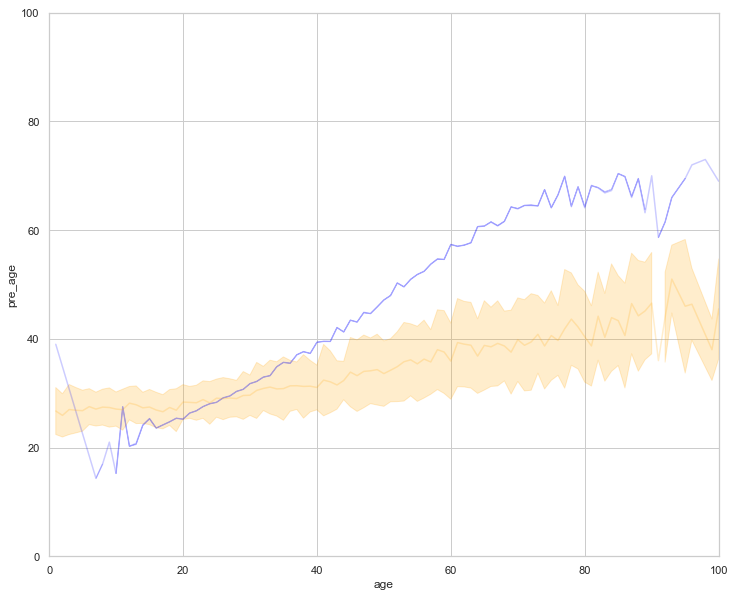

RMSE:  20.7
MAE : 17.4


In [5]:
# Plot the responses for different events and regions
plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="Actual", y="Prediction", data=df_wiki, alpha=0.2, ci=1, color = "blue")
sns.lineplot(x="age", y="pre_age", data=df_utk_crop, ci="sd", alpha=0.2, color = "orange")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = df_utk_crop["age"]
Y_pred = df_utk_crop["pre_age"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

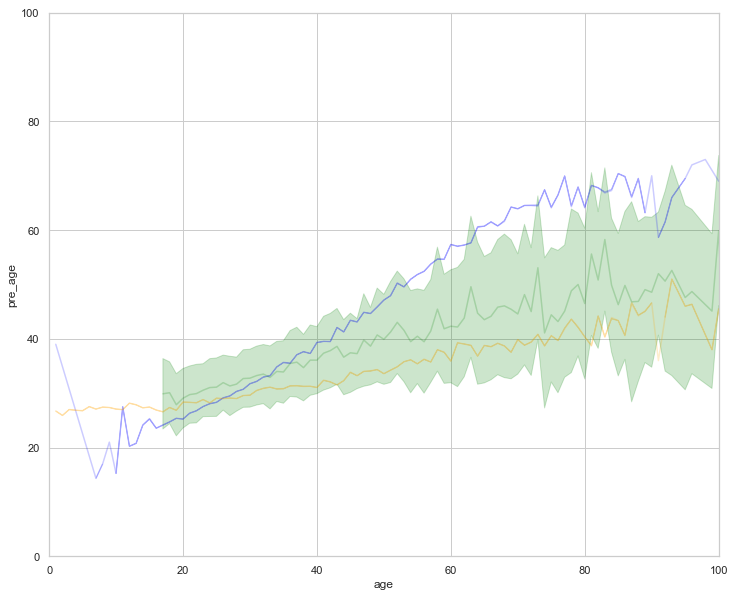

RMSE:  14.4
MAE : 10.1


In [6]:
# Plot the responses for different events and regions
plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="Actual", y="Prediction", data=df_wiki, ci=1, alpha=0.2, color = "blue")
sns.lineplot(x="age", y="pre_age", data=df_utk_crop, ci=1, alpha=0.2, color = "orange")
sns.lineplot(x="age", y="pre_age", data=df_utk_uncrop, ci="sd", alpha=0.2, color = "green")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = df_utk_uncrop["age"]
Y_pred = df_utk_uncrop["pre_age"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

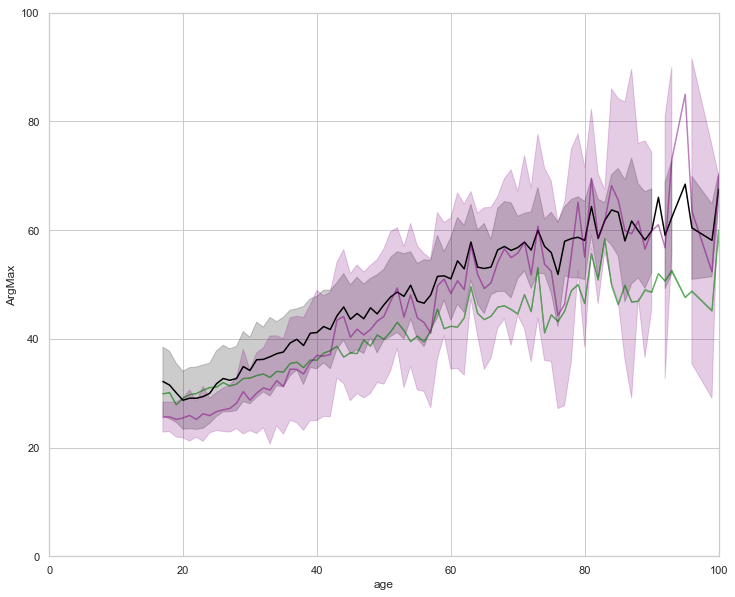

RMSE:  10.5
MAE : 7.8


In [7]:
# Plot the responses for different events and regions
plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

# sns.lineplot(x="Actual", y="Prediction", data=df_wiki, ci=1, alpha=0.2, color = "blue")
# sns.lineplot(x="age", y="pre_age", data=df_utk_crop, ci=1, alpha=0.2, color = "orange")
sns.lineplot(x="age", y="pre_age", data=df_utk_uncrop, ci=1, alpha=0.5, color = "green")
sns.lineplot(x="age", y="Weighted_Avg", data=df_retrain, ci="sd", alpha=1, color = "black")
sns.lineplot(x="age", y="ArgMax", data=df_retrain, ci="sd", alpha=0.5, color = "purple")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = df_retrain["age"]
Y_pred = df_retrain["Weighted_Avg"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

### DEEP DIVE INTO Re-TRAINED MODEL

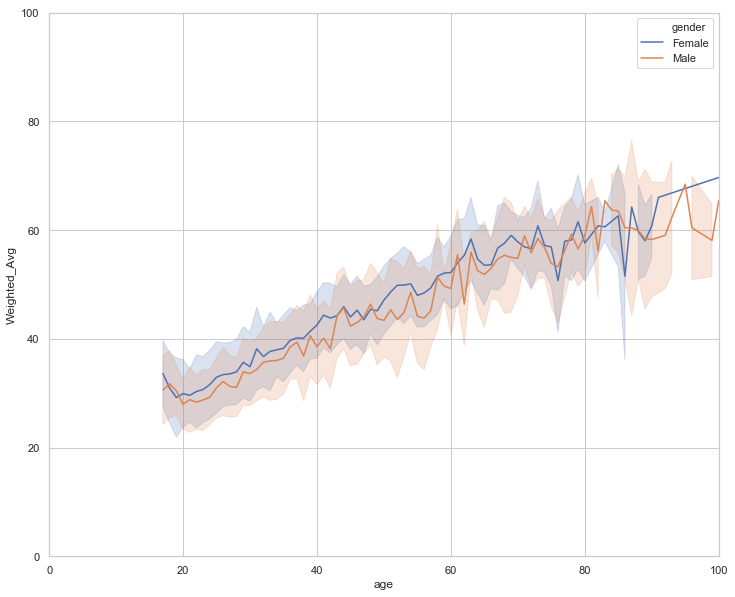

In [8]:
# Split by gender
plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="age", y="Weighted_Avg",
             hue="gender", data=df_retrain, ci="sd")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

### Races

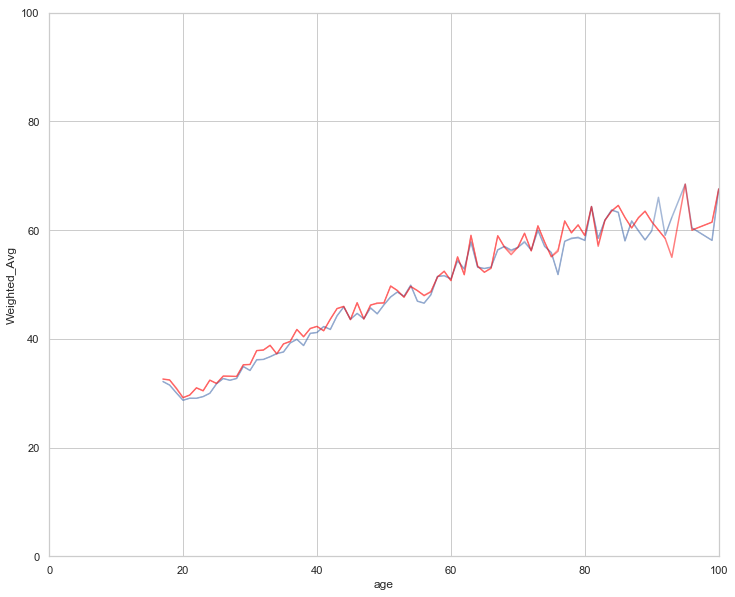

RMSE:  11.5
MAE : 8.7


In [9]:
# Race = White
mask = df_retrain["race"] == "White"
race = df_retrain[mask]

# Plot the responses for different events and regions
plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="age", y="Weighted_Avg", data=df_retrain, ci=1, alpha=0.5)
sns.lineplot(x="age", y="Weighted_Avg", data=race, ci=1, color= 'red', alpha=0.5)

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = race["age"]
Y_pred = race["Weighted_Avg"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

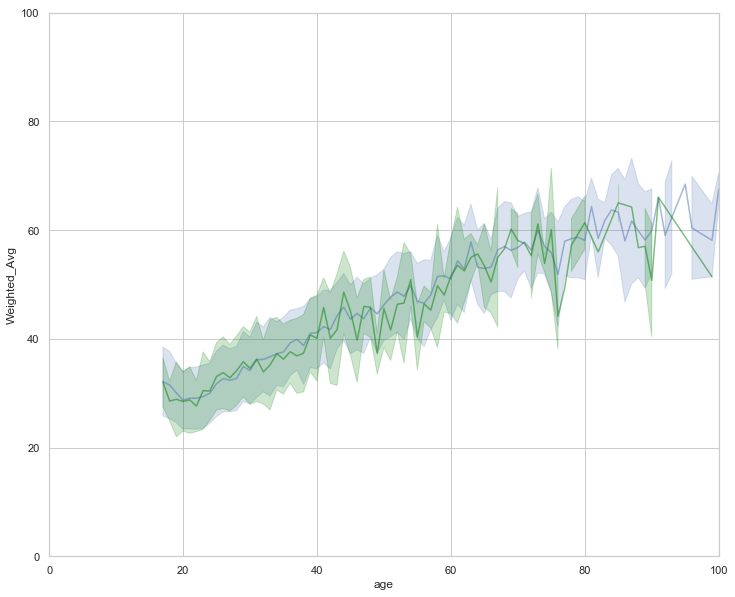

RMSE:  10.2
MAE : 7.6


In [10]:
# Race = Black
mask = df_retrain["race"] == "Black"
race = df_retrain[mask]

# Plot the responses for different events and regions
plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="age", y="Weighted_Avg", data=df_retrain, ci="sd", alpha=0.5)
sns.lineplot(x="age", y="Weighted_Avg", data=race, ci="sd", color= 'green', alpha=0.5)

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = race["age"]
Y_pred = race["Weighted_Avg"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

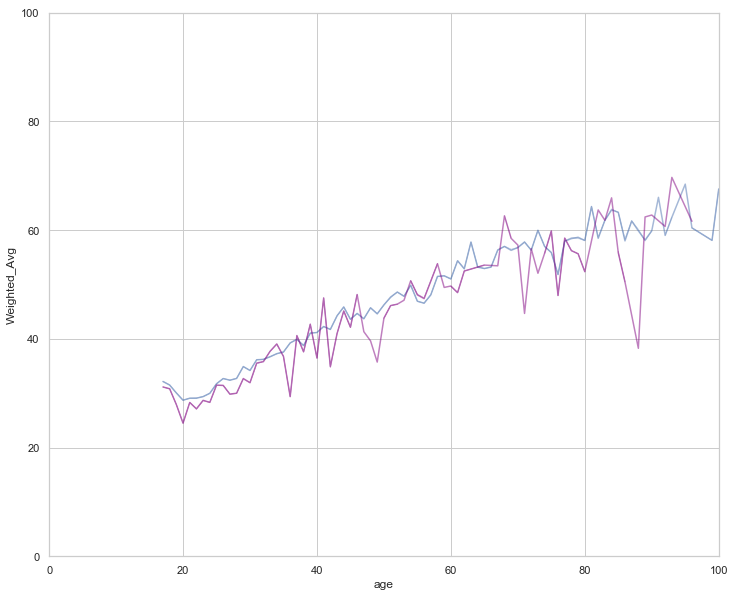

RMSE:  10.1
MAE : 7.0


In [11]:
# Race = Asian
mask = df_retrain["race"] == "Asian"
race = df_retrain[mask]

# Plot the responses for different events and regions
plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="age", y="Weighted_Avg", data=df_retrain, ci=1, alpha=0.5)
sns.lineplot(x="age", y="Weighted_Avg", data=race, ci=1, color= 'purple', alpha=0.5)

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = race["age"]
Y_pred = race["Weighted_Avg"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

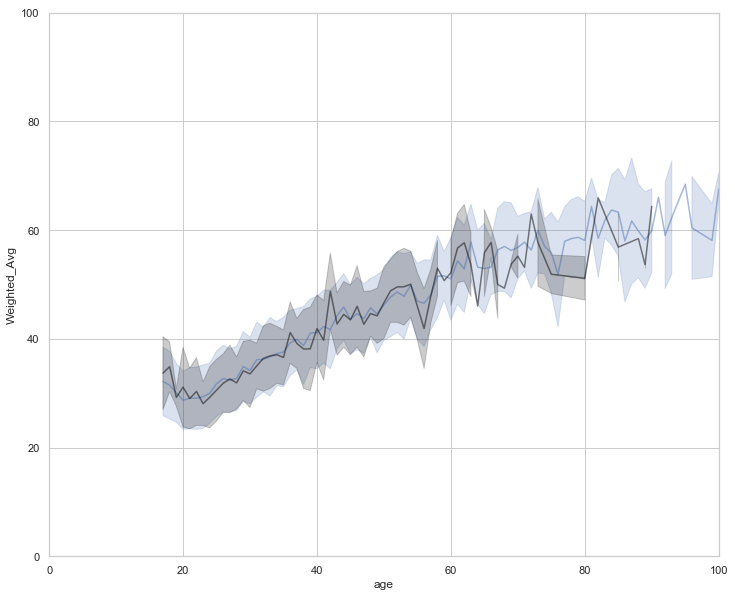

RMSE:  8.9
MAE : 6.6


In [12]:
# Race = Indian
mask = df_retrain["race"] == "Indian"
race = df_retrain[mask]

# Plot the responses for different events and regions
plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="age", y="Weighted_Avg", data=df_retrain, ci="sd", alpha=0.5)
sns.lineplot(x="age", y="Weighted_Avg", data=race, ci="sd", color= 'black', alpha=0.5)

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = race["age"]
Y_pred = race["Weighted_Avg"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

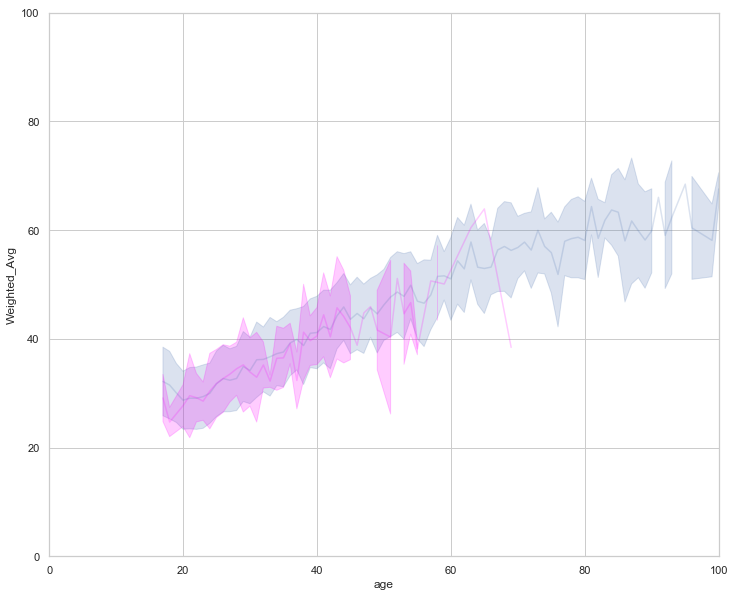

RMSE:  8.5
MAE : 6.5


In [13]:
# Race = Other
mask = df_retrain["race"] == "Other"
race = df_retrain[mask]

# Plot the responses for different events and regions
plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="age", y="Weighted_Avg", data=df_retrain, ci="sd", alpha=0.2)
sns.lineplot(x="age", y="Weighted_Avg", data=race, ci="sd", color= 'magenta', alpha=0.2)

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = race["age"]
Y_pred = race["Weighted_Avg"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

### CORRECTION MODEL

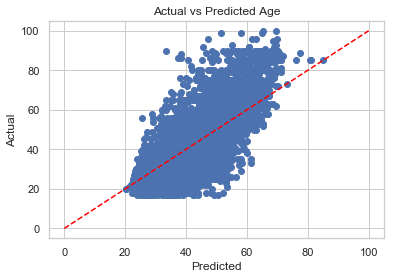

In [14]:
#Set up the data, check scatter
X = np.array(df_retrain["Weighted_Avg"])
X = np.reshape(X, (-1, 1))

r = range(0,101)
Y = df_retrain["age"]
Y = np.array(Y)
plt.scatter(X, Y)
plt.plot(r, r, color = 'red', linestyle = "--")
plt.xlabel('Predicted') 
plt.ylabel('Actual')
plt.title("Actual vs Predicted Age")
plt.show()

## Correcting Bias using orig predicted age, actual gender and actual race

In [15]:
#Set up data for training
X = pd.get_dummies(df_retrain, columns=['race']).drop(["age", "pixels", "ArgMax"], axis=1)
X["gender"] = X["gender"].replace({"Female":0, "Male":1})
Y = df_retrain["age"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 11)

In [16]:
#interested in pixel values for later analysis --> see how many are included per row
pixels = list(df_retrain["pixels"])
counter=[]

for x in pixels:
    counter.append(len(x))
    
pd.Series(counter).value_counts()

35    4848
29     966
23     101
dtype: int64

#### Linear Regression

In [17]:
linear = LinearRegression()
linear.fit(X_train, Y_train)
Y_pred = linear.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = math.sqrt(mean_squared_error(Y_test, Y_pred))

print("Intercept: " + str(linear.intercept_) + " Coef: " + str(linear.coef_))
print("MAE : " + str(round(mae,5)))
print("RMSE : " + str(round(rmse,5)))

Intercept: -9.691142772956503 Coef: [ 1.24724089  1.20257264  1.23997376 -0.59180954  0.00546431 -2.13422718
  1.48059865]
MAE : 7.31265
RMSE : 10.05618


#### Random Forest

In [18]:
RandomForestRegressorModel = RandomForestRegressor(n_estimators=50)
RandomForestRegressorModel.fit(X_train, Y_train)
Y_pred = RandomForestRegressorModel.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = math.sqrt(mean_squared_error(Y_test, Y_pred))

print("MAE : " + str(round(mae,5)))
print("RMSE : " + str(round(rmse,5)))

MAE : 8.08414
RMSE : 11.39602


In [19]:
RandomForestRegressorModel = RandomForestRegressor(n_estimators=500, max_depth = 64)
RandomForestRegressorModel.fit(X_train, Y_train)
Y_pred = RandomForestRegressorModel.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = math.sqrt(mean_squared_error(Y_test, Y_pred))

print("MAE : " + str(round(mae,5)))
print("RMSE : " + str(round(rmse,5)))

MAE : 8.11219
RMSE : 11.41176


#### Polynomial

In [20]:
#Fit data to a polynomial 
mae_list = []
rmse_list = []
poly_list = [2,3,4,5]

for p in poly_list:
    poly = PolynomialFeatures(degree=p)
    X_train_P = poly.fit_transform(X_train)
    X_test_P = poly.fit_transform(X_test)

    #run model
    reg = linear_model.LinearRegression()
    reg.fit(X_train_P, Y_train)
    y_pred_x_test_P = reg.predict(X_test_P)
    # print("Coef: " + str(reg.coef_))
    # print("Intercept: " + str(reg.intercept_))

    #Analyze model fit
    mae = mean_absolute_error(Y_test, y_pred_x_test_P)
    rmse = math.sqrt(mean_squared_error(Y_test, y_pred_x_test_P))
    mae_list.append(mae)
    rmse_list.append(rmse)  

best_poly = (np.argmin(rmse_list)+2)
    
print("MAEs: ")
print(*mae_list)
print("RMSEs: ")
print(*rmse_list)
print("Best polynomial is: ", best_poly)

MAEs: 
7.06342274563539 7.054452151410391 7.0530042230822225 7.048217764605379
RMSEs: 
9.888916910582722 9.913725109989867 9.95271914097973 10.042296799061376
Best polynomial is:  2


### Re-predict ages

In [25]:
#Predict new values of Y for all X's using model
poly = PolynomialFeatures(degree=best_poly)
X_P = poly.fit_transform(X)

#run model
reg = linear_model.LinearRegression()
reg.fit(X_P, Y)
y_new = pd.Series(reg.predict(X_P))
y_new = y_new.rename('revised_prediction')

df_new = pd.concat([df_retrain, y_new], axis=1)
df_new.head()

,age,gender,race,pixels,Weighted_Avg,ArgMax,revised_prediction
0,29,Female,Asian,[241. 186. 59. ... 242. 178. 72.],38.196539,26,37.470466
1,26,Female,White,[1. 2. 4. ... 3. 3. 3.],28.368421,26,26.778686
2,30,Male,Black,[38. 34. 23. ... 73. 75. 64.],31.629167,26,29.171097
3,28,Male,Asian,[ 93. 134. 196. ... 119. 135. 168.],39.201895,26,37.501810
4,56,Female,Indian,[54. 50. 39. ... 19. 9. 7.],48.839425,58,47.811189


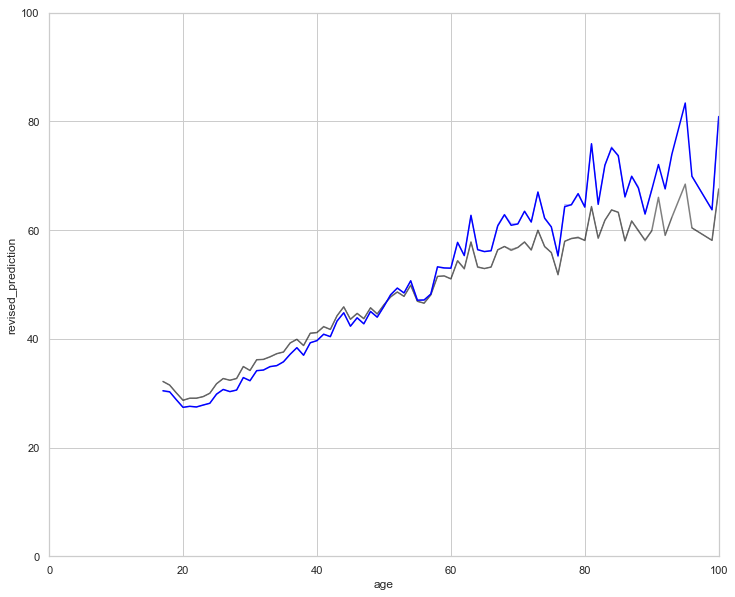

RMSE:  9.8
MAE : 7.1


In [24]:
# Plot the responses for different events and regions
plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="age", y="Weighted_Avg", data=df_retrain, ci=1, alpha=0.5, color = "black")
sns.lineplot(x="age", y="revised_prediction", data=df_new, alpha=1, ci=1, color = "blue")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = df_new["age"]
Y_pred = df_new["revised_prediction"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

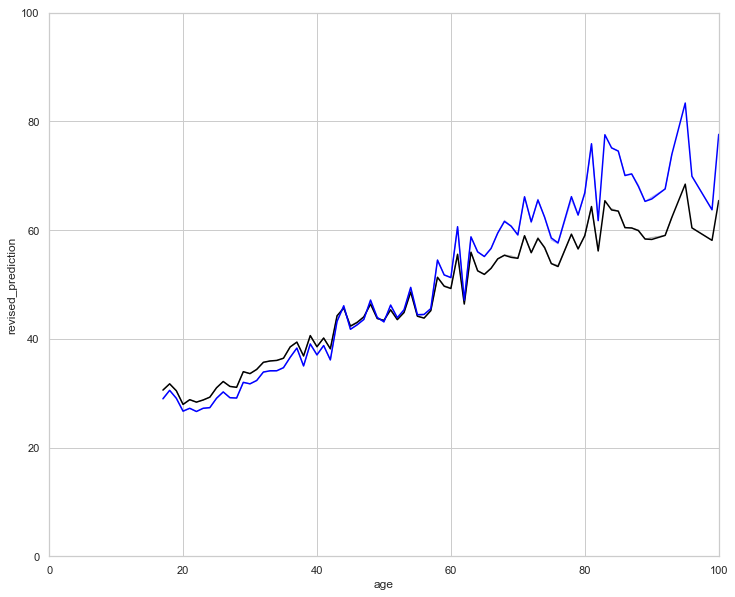

RMSE:  10.1
MAE : 7.1


In [40]:
###MALE
# Split by gender --> old vs new
mask = df_retrain["gender"] == "Male"
gender_retrain = df_retrain[mask]
mask = df_new["gender"] == "Male"
gender_new = df_new[mask]


plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="age", y="Weighted_Avg", data=gender_retrain, ci=1, color="black")
sns.lineplot(x="age", y="revised_prediction", data = gender_new, ci=1, color="blue")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = gender_new["age"]
Y_pred = gender_new["revised_prediction"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

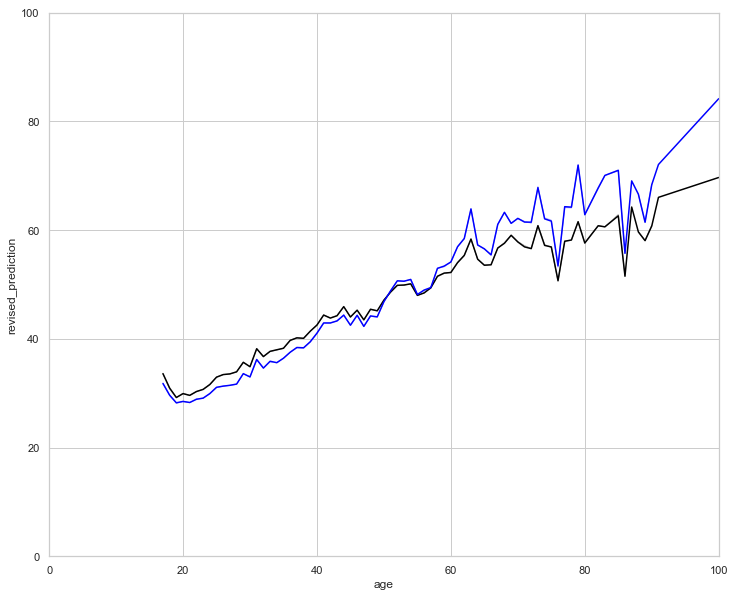

RMSE:  9.6
MAE : 7.1


In [41]:
###FEMALE
# Split by gender --> old vs new
mask = df_retrain["gender"] == "Female"
gender_retrain = df_retrain[mask]
mask = df_new["gender"] == "Female"
gender_new = df_new[mask]


plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="age", y="Weighted_Avg", data=gender_retrain, ci=1, color="black")
sns.lineplot(x="age", y="revised_prediction", data = gender_new, ci=1, color="blue")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = gender_new["age"]
Y_pred = gender_new["revised_prediction"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

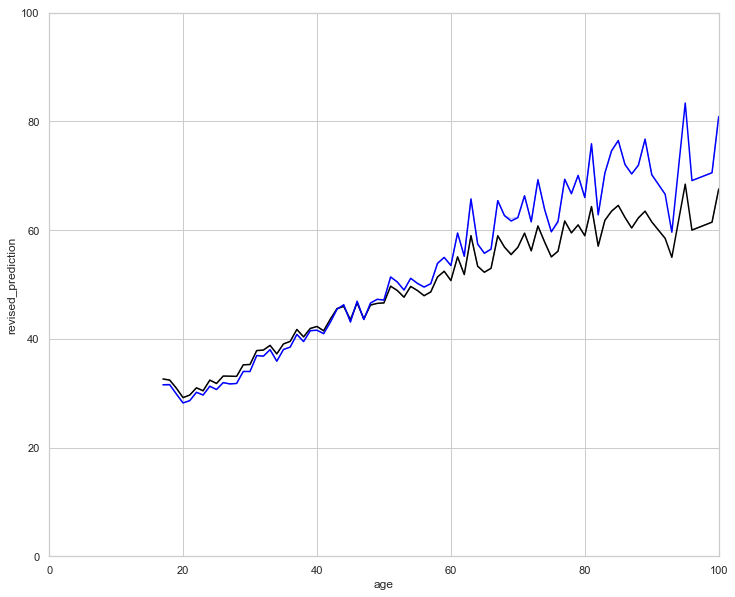

RMSE:  10.8
MAE : 8.0


In [42]:
###WHITE
# Split by gender --> old vs new
mask = df_retrain["race"] == "White"
race_retrain = df_retrain[mask]
mask = df_new["race"] == "White"
race_new = df_new[mask]


plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="age", y="Weighted_Avg", data=race_retrain, ci=1, color="black")
sns.lineplot(x="age", y="revised_prediction", data = race_new, ci=1, color="blue")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = race_new["age"]
Y_pred = race_new["revised_prediction"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

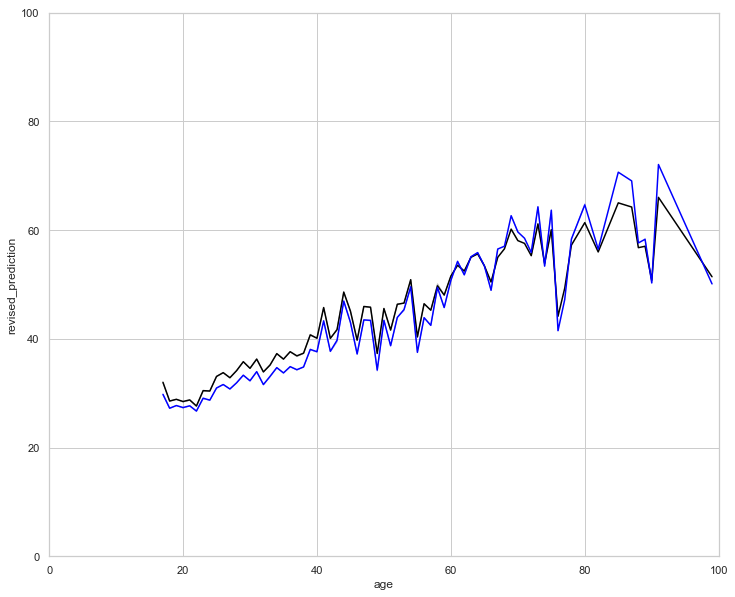

RMSE:  9.8
MAE : 7.0


In [43]:
###BLACK
# Split by gender --> old vs new
mask = df_retrain["race"] == "Black"
race_retrain = df_retrain[mask]
mask = df_new["race"] == "Black"
race_new = df_new[mask]


plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="age", y="Weighted_Avg", data=race_retrain, ci=1, color="black")
sns.lineplot(x="age", y="revised_prediction", data = race_new, ci=1, color="blue")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = race_new["age"]
Y_pred = race_new["revised_prediction"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

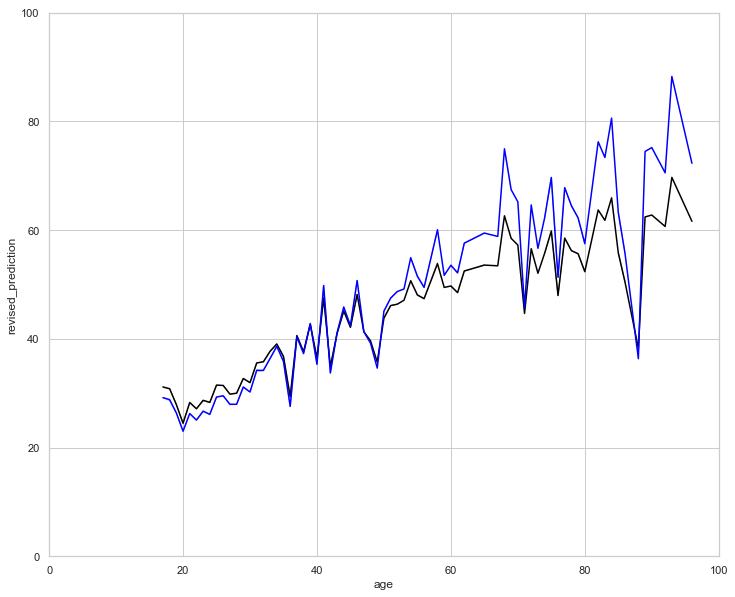

RMSE:  9.2
MAE : 6.2


In [44]:
###Asian
# Split by gender --> old vs new
mask = df_retrain["race"] == "Asian"
race_retrain = df_retrain[mask]
mask = df_new["race"] == "Asian"
race_new = df_new[mask]


plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="age", y="Weighted_Avg", data=race_retrain, ci=1, color="black")
sns.lineplot(x="age", y="revised_prediction", data = race_new, ci=1, color="blue")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = race_new["age"]
Y_pred = race_new["revised_prediction"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

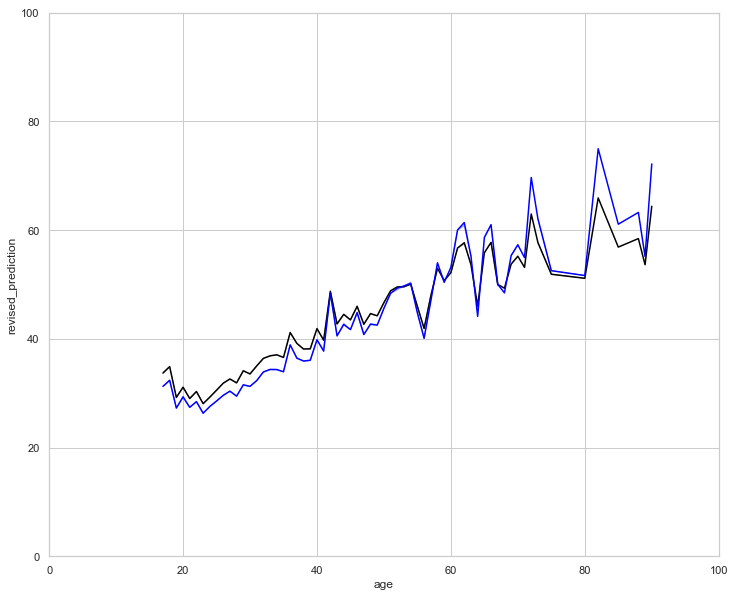

RMSE:  8.5
MAE : 6.1


In [45]:
###Indian
# Split by gender --> old vs new
mask = df_retrain["race"] == "Indian"
race_retrain = df_retrain[mask]
mask = df_new["race"] == "Indian"
race_new = df_new[mask]


plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="age", y="Weighted_Avg", data=race_retrain, ci=1, color="black")
sns.lineplot(x="age", y="revised_prediction", data = race_new, ci=1, color="blue")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = race_new["age"]
Y_pred = race_new["revised_prediction"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))

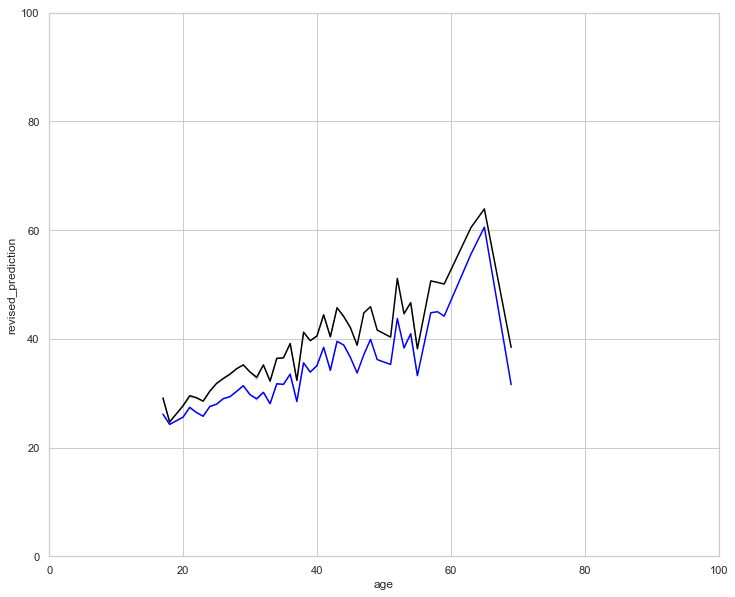

RMSE:  7.3
MAE : 5.3


In [46]:
###Other
# Split by gender --> old vs new
mask = df_retrain["race"] == "Other"
race_retrain = df_retrain[mask]
mask = df_new["race"] == "Other"
race_new = df_new[mask]


plt.figure(figsize=(12,10))
sns.set(style="whitegrid")

sns.lineplot(x="age", y="Weighted_Avg", data=race_retrain, ci=1, color="black")
sns.lineplot(x="age", y="revised_prediction", data = race_new, ci=1, color="blue")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.show()

Y_actual = race_new["age"]
Y_pred = race_new["revised_prediction"]

rmse = math.sqrt(mean_squared_error(Y_actual, Y_pred))
mae = mean_absolute_error(Y_actual, Y_pred)

print("RMSE: ", round(rmse,1))
print("MAE : " + str(round(mae,1)))